# 패키지 로드

In [1]:
#### Load package
import sys
import os
import re
import gc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import ray
import torch

from utils.common_util import time_train_frame
from utils.common_util import time_predict_frame

from datetime import datetime
from datetime import timedelta
from utils.logger import Logger

from utils.train_predict import fn_pred_valid_arima
from utils.train_predict import fn_set_seed
from utils.train_predict import fn_pred_valid_dl

## Console color
from IPython.core.ultratb import ColorTB

sys.excepthook = ColorTB()

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:.2f}".format
pd.options.display.min_rows = 10
pd.options.display.max_rows = 100
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 25

# Logging 모듈

In [2]:
## Logging Path
CREATED_TIME = datetime.now()
LOG_PATH = "./logs/"
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
## 로그 Naming
LOGFILE_NM = "web_traffic_forecast"
## Define Logger
logger = Logger(path=LOG_PATH, name=LOGFILE_NM, date=CREATED_TIME).logger

logger.info("Web Traffic Forecasing is Start")

2024-02-25 22:30:30,600 2520228684.py <module> Line 11 [INFO] Web Traffic Forecasing is Start


# Data 불러들이기

In [3]:
## File List
fileList = os.listdir("./data/")
train_ls = ["./data/" + file for file in fileList if file.startswith("train")]
key_ls = ["./data/" + file for file in fileList if file.startswith("key")]
sample_submission_ls = ["./data/" + file for file in fileList if file.startswith("sample_submission")]

## Load Data
trainData_DF = pd.concat([pd.read_csv(file) for file in train_ls], axis=0, ignore_index=True)
keyData_DF = pd.concat([pd.read_csv(file) for file in key_ls], axis=0, ignore_index=True)
submissionData_DF = pd.concat([pd.read_csv(file) for file in sample_submission_ls], axis=0, ignore_index=True)

logger.info("Train Data: {}".format(trainData_DF.shape))
logger.info("Key Data: {}".format(keyData_DF.shape))
logger.info("Submission Data: {}".format(submissionData_DF.shape))


## Count Unique Page, ID
logger.info("N-Unique of Page in TrainData: {}".format(trainData_DF["Page"].nunique()))
logger.info("N-Unique of Page in KeyData: {}".format(keyData_DF["Page"].nunique()))
logger.info("N-Unique of ID in KeyData: {}".format(keyData_DF["Id"].nunique()))

2024-02-25 22:31:30,052 3250961057.py <module> Line 12 [INFO] Train Data: (290126, 804)
2024-02-25 22:31:30,054 3250961057.py <module> Line 13 [INFO] Key Data: (17697686, 2)
2024-02-25 22:31:30,055 3250961057.py <module> Line 14 [INFO] Submission Data: (17697686, 2)
2024-02-25 22:31:30,160 3250961057.py <module> Line 18 [INFO] N-Unique of Page in TrainData: 145063
2024-02-25 22:31:45,294 3250961057.py <module> Line 19 [INFO] N-Unique of Page in KeyData: 17697686
2024-02-25 22:31:57,166 3250961057.py <module> Line 20 [INFO] N-Unique of ID in KeyData: 17697685


In [4]:
print('===== Train Data {} ===='.format(trainData_DF.shape))
print(trainData_DF.head(10))

print('===== Key Data {} ===='.format(keyData_DF.shape))
keyData_DF.head(10)

print('===== Submission Data {} ===='.format(submissionData_DF.shape))
submissionData_DF.head(10)

===== Train Data (290126, 804) ====
                            Page  2015-07-01  2015-07-02  2015-07-03  \
0  2NE1_zh.wikipedia.org_all-...       18.00       11.00        5.00   
1  2PM_zh.wikipedia.org_all-a...       11.00       14.00       15.00   
2  3C_zh.wikipedia.org_all-ac...        1.00        0.00        1.00   
3  4minute_zh.wikipedia.org_a...       35.00       13.00       10.00   
4  52_Hz_I_Love_You_zh.wikipe...         NaN         NaN         NaN   
5  5566_zh.wikipedia.org_all-...       12.00        7.00        4.00   
6  91Days_zh.wikipedia.org_al...         NaN         NaN         NaN   
7  A'N'D_zh.wikipedia.org_all...      118.00       26.00       30.00   
8  AKB48_zh.wikipedia.org_all...        5.00       23.00       14.00   
9  ASCII_zh.wikipedia.org_all...        6.00        3.00        5.00   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
0       13.00       14.00        9.00        9.00       22.00       26.00   
1       18.00    

,Id,Visits
0,bf4edcf969af,0
1,929ed2bf52b9,0
2,ff29d0f51d5c,0
3,e98873359be6,0
4,fa012434263a,0
5,48f1e93517a2,0
6,5def418fcb36,0
7,77bd08134351,0
8,5889e6dbb16f,0
9,5f21fef1d764,0


In [5]:
#### 제출용 Data 가공(Page -> Page, Date)

keyData_DF.rename({"Page": "Page_Date"}, axis=1, inplace=True)
keyData_DF["Page"] = keyData_DF["Page_Date"].apply(lambda x: "_".join(x.split("_")[:-1]))
keyData_DF["Date"] = keyData_DF["Page_Date"].apply(lambda x: x.split("_")[-1])

print('===== Key Data with Page -> Page + Date =====')
keyData_DF.head(5)

===== Key Data with Page -> Page + Date =====


,Page_Date,Id,Page,Date
0,!vote_en.wikipedia.org_all...,bf4edcf969af,!vote_en.wikipedia.org_all...,2017-01-01
1,!vote_en.wikipedia.org_all...,929ed2bf52b9,!vote_en.wikipedia.org_all...,2017-01-02
2,!vote_en.wikipedia.org_all...,ff29d0f51d5c,!vote_en.wikipedia.org_all...,2017-01-03
3,!vote_en.wikipedia.org_all...,e98873359be6,!vote_en.wikipedia.org_all...,2017-01-04
4,!vote_en.wikipedia.org_all...,fa012434263a,!vote_en.wikipedia.org_all...,2017-01-05


# 학습용 Data 생성

In [6]:
## Unpivot TrainData
trainData_Melt_DF = pd.melt(
    trainData_DF, id_vars="Page", var_name="Date", value_name="View", ignore_index=True
).dropna()

logger.info("TrainData - Unpivot: {}".format(trainData_Melt_DF.shape))

## 메모리 문제로 삭제
del trainData_DF
gc.collect()

2024-02-25 22:33:36,852 2557715310.py <module> Line 6 [INFO] TrainData - Unpivot: (183049960, 3)


0

In [7]:
print("===== Train Data with Unpivot =====")
trainData_Melt_DF.head(5)

===== Train Data with Unpivot =====


,Page,Date,View
0,2NE1_zh.wikipedia.org_all-...,2015-07-01,18.00
1,2PM_zh.wikipedia.org_all-a...,2015-07-01,11.00
2,3C_zh.wikipedia.org_all-ac...,2015-07-01,1.00
3,4minute_zh.wikipedia.org_a...,2015-07-01,35.00
5,5566_zh.wikipedia.org_all-...,2015-07-01,12.00


In [8]:
## 상위 N 페이지
TOP_N = 500
pageViewMedian = trainData_Melt_DF.groupby("Page")["View"].median().reset_index(name="View_Median")
pageViewMedian.sort_values(["View_Median"], ascending=False, inplace=True)
topPageList = pageViewMedian[:TOP_N]["Page"].tolist()

## 상위 N개 페이지만 Filtering(Local PC 메모리 문제)
trainFilter_DF = (trainData_Melt_DF[trainData_Melt_DF["Page"].isin(topPageList)]).reset_index(drop=True)

logger.info("Target Page CNT: {}".format(trainFilter_DF["Page"].nunique()))

2024-02-25 22:35:09,257 829177245.py <module> Line 10 [INFO] Target Page CNT: 500


# 예측모델 방법론
    1. Auto_ARIMA
    2. CPT(Change Point Detection) + FREQ_Arima(통계적으로 Frequency Detection)
    3. Informer
    4. SCINet
    5. NLinear
    6. Augogleon(Automl 패키지) => Runtime이 너무 길어서 X

    => PV 상위 500개 페이지에 대해 ARIMA 모델 성능검증
    => ARIMA 기반 모델의 예측성능이 좋지 않은 경우, 딥러닝 모델 수행(상위 30개)
    => 딥러닝 모델 성능검증 및 모델 선택

In [9]:
#### 예측모델 Setting

## Train Loss 및 Prediction Plot 저장(.png) 여부
LOSS_PLOT_TF = True
## Validation Loss 계산 여부
VALID_YN = True

## DL모델의 Hyper-parameter Tuning 여부(Informer_New, SCINet, NLinear의 train_epoch)
## 운영시 True 가능 / False일 경우, 지정된 train_epoch만큼 학습하게 됨
PARA_TUNE_YN = True

DATA_PERCENTAGE = 0.7

## DL모델 종류: DL 알고리즘을 선택, options: ["Informer", "SCINet", "NLinear"]
## 운영 시 하나의 모델만 리스트로 담겨있어야 함(Ex. DL_Model_LS = ["NLinear"])
DL_Model_LS = ["Informer", "SCINet", "NLinear"]

## PyTorch Device: GPU 가용 시 변경 필요
TORCH_DEVICE = torch.device("cpu")

## 병렬 코어
CORE_CNT = os.cpu_count()
torch.set_num_threads(CORE_CNT)
torch.set_num_interop_threads(CORE_CNT)

## 분석대상 Page List
# pageList = trainFilter_DF["Page"].unique().tolist()
pageList = topPageList

## 예측기간(2017-09-11 ~ 2017-11-13)
PRED_DAY = 64  # (datetime(2017,11,13,0,0,0) - datetime(2017,9,11,0,0,0)).days + 1
TRAIN_DAY = 365

In [10]:
#### 모델검증

## 모델 검증을 위한 수행일자 설정
dateList = [datetime.strptime("2017-09-11", "%Y-%m-%d") + timedelta(days=-PRED_DAY * x0) for x0 in range(1, 6)]

i0 = 0
## 분석 기준일자, Ex) 2017-07-13
# ANAL_DATE = datetime.strptime("2017-09-11", "%Y-%m-%d")
ANAL_DATE = dateList[i0]

logger.info("Date: {}({}/{}) is Start".format(ANAL_DATE, i0 + 1, len(dateList)))

## 분석결과 폴더: EX) "./result/20230102/"
RESULT_PATH = "./result/{}/".format(re.sub("-", "", str(ANAL_DATE)[:10]))
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)


## 학습 시작일, 마지막일, 일별 table, Ex) 2017-01-14 ~ 2017-07-12
START_DATE, END_DATE, TS_DAY = time_train_frame(TRAIN_DAY, ANAL_DATE)

## 예측 기간(일별 예측기간, 월별 예측기간), Ex) 2017-07-13 ~ 2017-09-12
(
    PRED_ST_DATE,
    PRED_DAY_END_DATE,
    predDays,
) = time_predict_frame(PRED_DAY, ANAL_DATE)

## ARIMA Plot 경로 생성
if not os.path.exists(RESULT_PATH + "/TrainLossPlot/ARIMA"):
    os.makedirs(RESULT_PATH + "/TrainLossPlot/ARIMA")

2024-02-25 22:35:09,338 367530982.py <module> Line 11 [INFO] Date: 2017-07-09 00:00:00(1/5) is Start


## 1. ARIMA 모델 검증 결과

In [11]:
# ## 결과 List
# predict_Result_LS = []
# errorList = []
# for t0, PAGE_NM in enumerate(pageList):
#     # t0 = 2
#     # PAGE_NM = pageList[t0]
#     logger.info("Page({}/{}) is Start".format(t0 + 1, len(pageList)))

#     try:
#         ## Page Filtering
#         train_df = trainFilter_DF[trainFilter_DF["Page"] == PAGE_NM]
#         ## Date Filtering
#         train_df = train_df[(train_df["Date"] >= START_DATE) & (train_df["Date"] <= PRED_DAY_END_DATE)]
#         ## 정렬
#         train_df.sort_values("Date", ascending=True, inplace=True)
#         ## Index initialization
#         train_df.reset_index(drop=True, inplace=True)

#         ## Seed 고정
#         fn_set_seed()

#         ## Arima
#         predict_Result = fn_pred_valid_arima(
#             page_nm=PAGE_NM,
#             date_nm="Date",
#             value_nm="View",
#             page_nm_df=train_df,
#             start_date=START_DATE,
#             end_date=END_DATE,
#             pred_st_date=PRED_ST_DATE,
#             pred_day_end_date=PRED_DAY_END_DATE,
#             pred_days=predDays,
#             logger=logger,
#             valid_yn=VALID_YN,
#             data_percentage=DATA_PERCENTAGE,
#             loss_plot_tf=LOSS_PLOT_TF,
#             loss_plot_path=RESULT_PATH + "/TrainLossPlot/ARIMA",
#         )

#         predict_Result_LS.append(predict_Result)
#     except Exception as e:
#         logger.error("Error in Page({}/{})".format(t0 + 1, len(pageList)))
#         logger.error(e)
#         errorList.append(t0)


# ## 예측치
# predict_Day_DF = pd.concat([x[0] for x in predict_Result_LS], axis=0, ignore_index=True)

# ## Arima 모델 요약
# predict_Summary_DF = pd.concat([x[1] for x in predict_Result_LS], axis=0, ignore_index=True)

# ## DL 알고리즘 적용대상
# dl_Alg_ID_LS = [x[2] for x in predict_Result_LS]
# ## Filter None
# dl_Alg_ID_LS = list(filter(None, dl_Alg_ID_LS))

# logger.info(
#     "ARIMA SMAPE: {} w/ CNT: {}".format(
#         predict_Summary_DF["SMAPE_ARIMA"].median(), 
#         predict_Summary_DF.shape[1]
#     )
# )
# logger.info("DL Target CNT: {}".format(len(dl_Alg_ID_LS)))
# logger.info("Date: {}({}/{}) is End".format(ANAL_DATE, i0 + 1, len(dateList)))

* ARIMA 작업을 Ray를 통한 병렬로 작업함
  - 전체 Page를 CPU 갯수만큼의 리스트로 각각 분할하고, 각 리스트를 병렬로 작업함
  - 하나의 병렬 Process 내에서는 Page를 순차적으로 작업함

In [12]:
## List를 CPU갯수 만큼 분할(Ex. [1,2,...,10], CPU 4개 => [[1,2,3], [4,5,6], [7,8,9], [10]]
def fn_split_list(mylist, split_cnt):
    return [
        mylist[i0 : (i0 + split_cnt)] for i0 in range(0, len(mylist), split_cnt)
    ]
pageSplit_LS = fn_split_list(pageList, len(pageList) // CORE_CNT + 1)

TMP_ST_TIME = datetime.now()

## Parallel computing by Ray
ray.init(
    num_cpus=min(len(pageSplit_LS), CORE_CNT),
    local_mode=[True if min(len(pageSplit_LS), CORE_CNT) == 1 else False][0],
    # local_mode=True,
)

@ray.remote
def fn_predvalid_ray(
    page_nm_ls: list,
    data_df: pd.DataFrame,
    start_date: str,
    end_date: str,
    pred_st_date: str,
    pred_day_end_date: str,
    pred_days: pd.DataFrame,
    created_time: None,
    log_path: str,
    logger_name: str,
    valid_yn: bool = False,
    data_percentage: float = 0.7,
    loss_plot_tf: bool = False,
    loss_plot_path: str = "./result/TrainLossPlot/ARIMA"
):
    """
    모델 학습 및 검증(fn_pred_valid_arima)을 병렬적으로 수행하는 함수
    Informer 등 Arima 외 모델을 적용할 경우
    해당 Page의 train/test를 담은 class를 리턴함
    (ChangePoint 함수를 두 번 수행하지 않기 위함)

    Returns:
            predict_day_df: 일별 예측치
            predict_summary_df: Arima 모델의 성능, 수행시간 등 요약정보
            dl_alg_id_ls: ARIMA외 모델을 적용할 경우 해당 Page에 대한 Class
    """

    import os
    import pandas as pd
    
    import logging
    from utils.logger import Logger
    
    from utils.train_predict import fn_set_seed
    from utils.train_predict import fn_pred_valid_arima

    import warnings
    
    warnings.simplefilter(action="ignore", category=FutureWarning)
    warnings.simplefilter(action="ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore")

    logger = Logger(path=log_path, name=logger_name, date=created_time).logger
    logging.basicConfig(level=logging.DEBUG)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

    logger.info("PID:{} is Start".format(os.getpid()))
    
    ## Seed 고정
    fn_set_seed()

    ## 학습/예측 함수 수행
    predict_result = list(
        map(
            fn_pred_valid_arima,
            page_nm_ls,
            ['Date' for x in range(len(page_nm_ls))],
            ['View' for x in range(len(page_nm_ls))],
            [
                data_df[(data_df["Page"] == page_nm_ls[x])][["Date", "View"]]
                for x in range(len(page_nm_ls))
            ],
            [start_date for x in range(len(page_nm_ls))],
            [end_date for x in range(len(page_nm_ls))],
            [pred_st_date for x in range(len(page_nm_ls))],
            [pred_day_end_date for x in range(len(page_nm_ls))],
            [pred_days for x in range(len(page_nm_ls))],
            [logger for x in range(len(page_nm_ls))],
            [valid_yn for x in range(len(page_nm_ls))],
            [data_percentage for x in range(len(page_nm_ls))],
            [loss_plot_tf for x in range(len(page_nm_ls))],
            [loss_plot_path for x in range(len(page_nm_ls))]
        )
    )
    
    predict_day_df = pd.concat(
        [x[0] for x in predict_result], axis=0, ignore_index=True
    )
    predict_summary_df = pd.concat(
        [x[1] for x in predict_result], axis=0, ignore_index=True
    )
    dl_alg_id_ls = [x[2] for x in predict_result]

    logger.info("PID: {} is End".format(os.getpid()))

    return predict_day_df, predict_summary_df, dl_alg_id_ls

## Define map function
def fn_par_map(f, page_split_list):
    return [
        f.remote(
            page_list,
            trainData_Melt_DF[trainData_Melt_DF["Page"].isin(page_list)],
            START_DATE,
            END_DATE,
            PRED_ST_DATE,
            PRED_DAY_END_DATE,
            predDays,
            CREATED_TIME,
            LOG_PATH,
            LOGFILE_NM,
            VALID_YN,
            DATA_PERCENTAGE,
            LOSS_PLOT_TF,
            RESULT_PATH + "/TrainLossPlot/ARIMA",
        )
        for page_list in page_split_list
    ]
    
try:
    ## Do Parallel
    Result_ParMap = fn_par_map(fn_predvalid_ray, pageSplit_LS)
    ## Get Result
    ResultParallel = ray.get(Result_ParMap)

except Exception as e:
    logger.error("Error in Ray")
    raise Exception(e)

finally:
    ## Closs parallel computting
    ray.shutdown(True)

    ## 종료시간
    TMP_END_TIME = datetime.now()
    logger.info(
        "ARIMA Elapsed Time: {} Minutes".format(
            round((TMP_END_TIME - TMP_ST_TIME).seconds / 60, 2)
        )
    )

#### Get Arima Result
## 예측치
predictDay_DF = pd.concat([x[0] for x in ResultParallel], axis=0, ignore_index=True)
## Arima 모델 요약
predictSummary_DF = pd.concat(
    [x[1] for x in ResultParallel], axis=0, ignore_index=True
)
## DL 알고리즘 적용대상
dl_Alg_ID_LS = [x[2] for x in ResultParallel]
## Flatten
dl_Alg_ID_LS = [y for x in dl_Alg_ID_LS for y in x]
## Filter None
dl_Alg_ID_LS = list(filter(None, dl_Alg_ID_LS))

2024-02-25 22:35:14,857	INFO worker.py:1724 -- Started a local Ray instance.
(fn_predvalid_ray pid=26324) 2024-02-25 22:35:35,708 104710503.py fn_predvalid_ray Line 65 [INFO] PID:26324 is Start
(fn_predvalid_ray pid=26324) INFO:web_traffic_forecast:PID:26324 is Start
(fn_predvalid_ray pid=26324) DEBUG:web_traffic_forecast:Page: Main_Page_en.wikipedia.org_all-access_all-agents is Start
(fn_predvalid_ray pid=26888) DEBUG:web_traffic_forecast:Page: Main_Page_commons.wikimedia.org_desktop_all-agents is Start
(fn_predvalid_ray pid=26324) DEBUG:web_traffic_forecast:Page: Main_Page_en.wikipedia.org_desktop_all-agents is Start
(fn_predvalid_ray pid=26324) DEBUG:web_traffic_forecast:Page: Main_Page_en.wikipedia.org_mobile-web_all-agents is Start
(fn_predvalid_ray pid=26888) 2024-02-25 22:35:43,323 104710503.py fn_predvalid_ray Line 65 [INFO] PID:26888 is Start
(fn_predvalid_ray pid=26888) INFO:web_traffic_forecast:PID:26888 is Start
(fn_predvalid_ray pid=16120) 2024-02-25 22:35:56,790 104710503

In [13]:
logger.info(
    "ARIMA SMAPE: {} w/ CNT: {}".format(
        predictSummary_DF["SMAPE"].median(), 
        predictSummary_DF.shape[1]
    )
)
logger.info("DL Target CNT: {}".format(len(dl_Alg_ID_LS)))
logger.info("Date: {}({}/{}) is End".format(ANAL_DATE, i0 + 1, len(dateList)))

2024-02-26 01:00:27,291 4281116992.py <module> Line 1 [INFO] ARIMA SMAPE: 11.245393232489157 w/ CNT: 25
2024-02-26 01:00:27,292 4281116992.py <module> Line 7 [INFO] DL Target CNT: 75
2024-02-26 01:00:27,293 4281116992.py <module> Line 8 [INFO] Date: 2017-07-09 00:00:00(1/5) is End


MAPE(ARIMA): 65.78067040733015


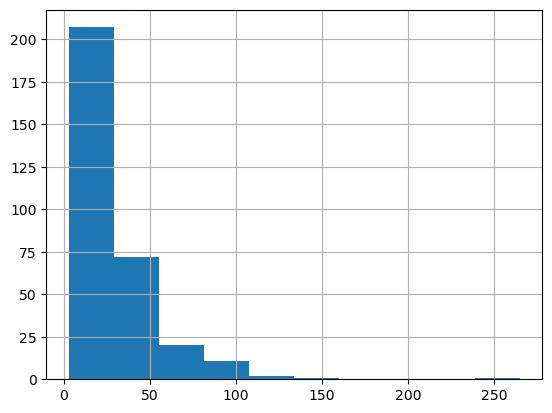

SMAPE(ARIMA): 14.828269364640727


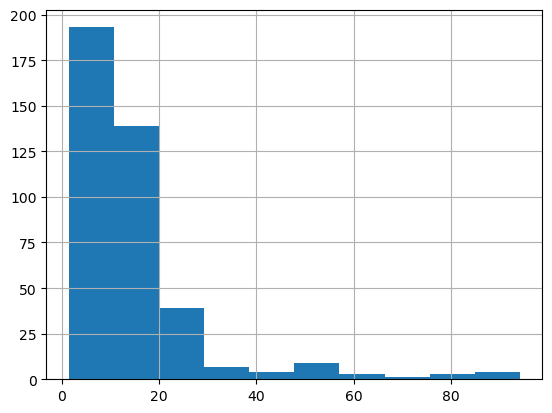

MDAPE(ARIMA): 41.79369286876027


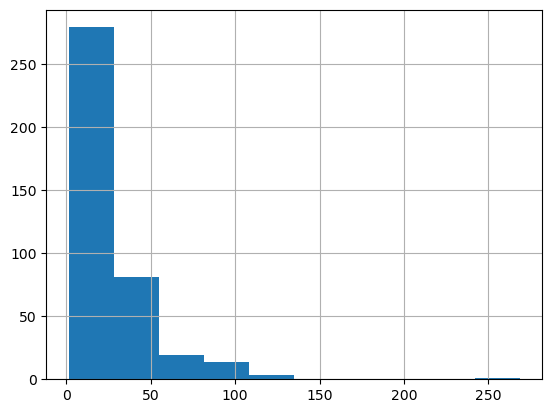

ADJ_MAPE(ARIMA): 61.07152840150799


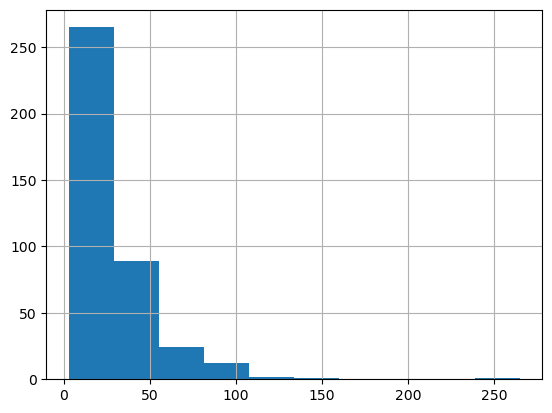

REV_MAPE(ARIMA): 34.957410391520014


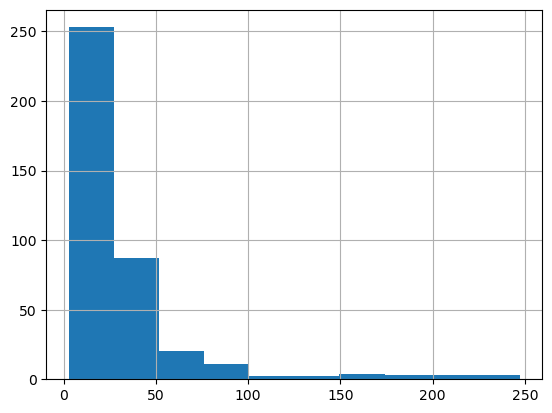

MASE(ARIMA): 2.6401773279241043


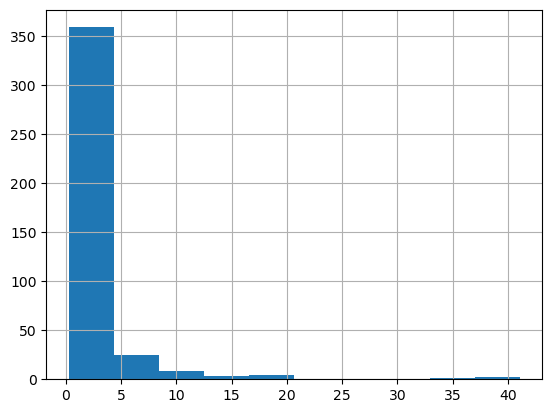

CORRELATION(ARIMA): nan


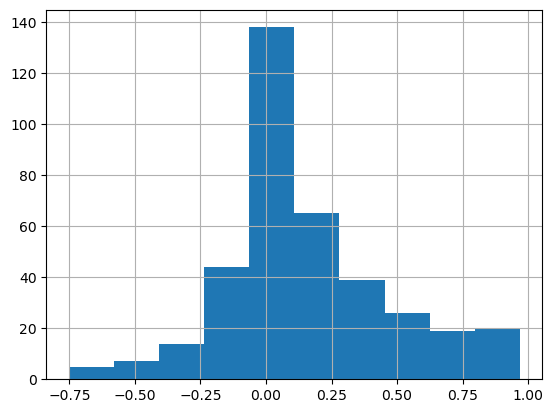

In [14]:
%matplotlib inline
for SCORE_NM in ['MAPE', 'SMAPE', 'MDAPE', 'ADJ_MAPE', 'REV_MAPE', 'MASE', 'CORRELATION']:
    print('{}(ARIMA): {}'.format(SCORE_NM, np.mean([x for x in predictSummary_DF[SCORE_NM].values if x != float('inf')])))
    predictSummary_DF[predictSummary_DF[SCORE_NM] < 500][SCORE_NM].hist()
    plt.show()

In [15]:
from IPython.display import Image

print('FREQ_ARIMA: {}'.format(predictSummary_DF['FREQ_YN'].sum()))
print('Change Point is Exist: {}'.format(predictSummary_DF['PELT'].sum()))

FREQ_ARIMA: 241
Change Point is Exist: 332


In [175]:
freq1_cpt1_DF = predictSummary_DF[
    (predictSummary_DF['FREQ_YN'] == 1)
    | (predictSummary_DF['PELT'] is True)
]

## Frequency, CPT 적용된 Case 10개 Plot
if freq1_cpt1_DF.shape[0] > 0:
    for i0 in range(min(10, len(freq1_cpt1_DF))):
        Image(f"result/{str(ANAL_DATE)[:10].replace('-', '')}/" + freq1_cpt1_DF['LOSS_PLOT_FILE'].values[i0])

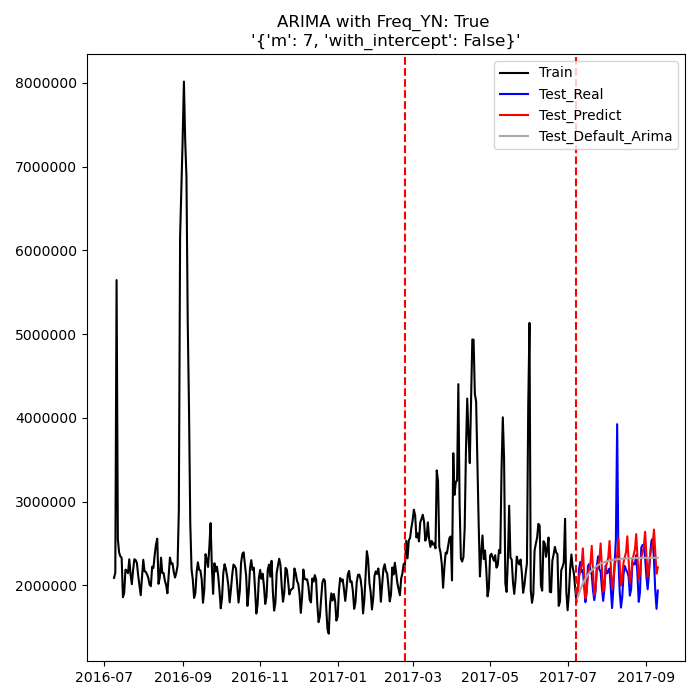

In [180]:
## Frequency, CPT 적용 예시
Image(f"result/{str(ANAL_DATE)[:10].replace('-', '')}/" + freq1_cpt1_DF['LOSS_PLOT_FILE'].values[1])

## 2. 딥러닝 모델 검증 결과

In [17]:
## DL모델의 Hyper-Parameter 세팅
ParaSpace = {
    "Informer": {
                "seq_len": PRED_DAY,
                "label_len": PRED_DAY,  
                "pred_len": PRED_DAY,
                "learning_rate": 1e-4,
                "train_epochs": 100 if PARA_TUNE_YN is True else 50,
                "batch_size": 64,
                "n_heads": 8,
                "e_layers": 3,
                "d_layers": 2,
                "dropout": 0.05,
                "d_model": 512,
                "d_ff": 512,
                "embed": "fixed",
                "freq": "d",
                "adjust_learning_rate_yn": True,
                "loss_plot_path": "{}/Informer".format(RESULT_PATH + "/TrainLossPlot"),
            },
    "SCINet": {
            "seq_len": PRED_DAY,
            "label_len": PRED_DAY,
            "pred_len": PRED_DAY,
            "train_epochs": 100 if PARA_TUNE_YN is True else 50,
            "kernel": 9,
            "embed": "timeF",  ## 'fixed', 'timeF'
            "dropout": 0.3,
            "lr": 1e-3,
            "freq": "b",
            "hidden_size": 125,
            "batch_size": 64,
            "levels": 3,
            "decompose": True,
            "adjust_learning_rate_yn": True,
            "path": "{}/SCINet".format(RESULT_PATH + "/TrainLossPlot"),
        },
    "NLinear": {
            "seq_len": PRED_DAY,
            "label_len": PRED_DAY,
            "pred_len": PRED_DAY,
            "train_epochs": 1000 if PARA_TUNE_YN is True else 750,
            "learning_rate": 1e-3,
            "batch_size": 64,
            "enc_in": 7,
            "scale_yn": True,
            "individual": False,
            "adjust_learning_rate_yn": True,
            "loss_plot_path": "{}/NLinear".format(RESULT_PATH + "/TrainLossPlot"),
        },
}

In [18]:
## 50개 Page만 검증(Runtime이 너무 오래걸림)
dl_Alg_ID_LS_Top50 = dl_Alg_ID_LS[:50]

if (len(dl_Alg_ID_LS_Top50) > 0) & (len(DL_Model_LS) > 0):
    for DL_TYPE in DL_Model_LS:
        ## DL 결과 초기화
        predictDay_DL_DF = pd.DataFrame()
        predictSummary_DL_DF = pd.DataFrame()
        ERROR_DL = ""

        ## 시작시간
        TMP_ST_TIME = datetime.now()

        logger.info("{}(Deep learning) Start".format(DL_TYPE))

        ## 계정별 순차적으로 DL모델 학습 및 예측 진행
        for a0, dlClass in enumerate(dl_Alg_ID_LS_Top50):
            logger.info(
                "({}/{}){}: Use {}".format(
                    a0 + 1, len(dl_Alg_ID_LS_Top50), dlClass.page_nm, DL_TYPE
                )
            )

            ## Early stop 적용할 patience 수
            if DL_TYPE == "Informer":
                PATIENCE_CNT = 15
            elif DL_TYPE == "SCINet":
                PATIENCE_CNT = 30
            elif DL_TYPE == "NLinear":
                PATIENCE_CNT = 100
            else:
                PATIENCE_CNT = 30

            try:
                ## Run Informer
                fn_pred_valid_dl(
                    pred_result=dlClass,
                    device=TORCH_DEVICE,
                    loss_plot_yn=LOSS_PLOT_TF,
                    valid_yn=VALID_YN,
                    para_tune_yn=PARA_TUNE_YN,
                    patience=PATIENCE_CNT,
                    algo=DL_TYPE,
                    para_space=ParaSpace[DL_TYPE],
                    arima_loss_plot_path=RESULT_PATH + "/TrainLossPlot/ARIMA",
                    logger=logger
                )

                ## DL 모델의 예측 결과
                (
                    predictDay_DL_TMP_DF,
                    predictSummary_DL_TMP_DF
                ) = dlClass.model_performance(
                    valid_yn=VALID_YN,
                    loss_plot_tf=LOSS_PLOT_TF
                )

                ## Combine Result
                predictDay_DL_DF = pd.concat(
                    [predictDay_DL_DF, predictDay_DL_TMP_DF],
                    axis=0,
                    ignore_index=True,
                )
                predictSummary_DL_DF = pd.concat(
                    [predictSummary_DL_DF, predictSummary_DL_TMP_DF],
                    axis=0,
                    ignore_index=True,
                )

            except Exception as e:
                if VALID_YN is True:
                    ## 수동 검증 시, Error가 발생할 경우 해당 Page의 DL모델 Process를 중단함
                    raise Exception(e)
                else:
                    ## 최종 결과물의 경우, 해당 Page의 예측결과를 제외하고 다음 계정에 대해 진행
                    ## DL에서 Error가 발생하여, ARIMA 모델을 대체했음에도 에러가 발생한 경우임
                    logger.error(e)

        ## 최종결과 할당(Ex. Predict_Informer_DF, PredictSummary_Informer_DF
        (
            globals()["predictDay_{}_DF".format(DL_TYPE)],
            globals()["predictSummary_{}_DF".format(DL_TYPE)]
        ) = (
            predictDay_DL_DF.copy(),
            predictSummary_DL_DF.copy()
        )

        ## 종료시간
        TMP_END_TIME = datetime.now()
        logger.info(
            "{} Elapsed Time: {} Minutes".format(
                DL_TYPE, round((TMP_END_TIME - TMP_ST_TIME).seconds / 60, 2)
            )
        )



2024-02-26 01:00:28,770 2395440504.py <module> Line 14 [INFO] Informer(Deep learning) Start
2024-02-26 01:00:28,771 2395440504.py <module> Line 18 [INFO] (1/50)Special:CreateAccount_commons.wikimedia.org_all-access_all-agents: Use Informer
Train loss: 0.926887, Valid loss: 0.344013: 100%|██████████| 30/30 [10:35<00:00, 21.18s/it]
2024-02-26 01:27:28,596 2395440504.py <module> Line 18 [INFO] (2/50)Special:CreateAccount_commons.wikimedia.org_desktop_all-agents: Use Informer
Train loss: 0.928165, Valid loss: 0.328284: 100%|██████████| 30/30 [10:52<00:00, 21.75s/it]
2024-02-26 01:55:03,275 2395440504.py <module> Line 18 [INFO] (3/50)Special:CreateAccount_en.wikipedia.org_all-access_all-agents: Use Informer
Train loss: nan, Valid loss: 0.426912: 100%|██████████| 36/36 [00:05<00:00,  6.46it/s]
2024-02-26 01:55:17,772 2395440504.py <module> Line 18 [INFO] (4/50)Special:CreateAccount_en.wikipedia.org_desktop_all-agents: Use Informer
Train loss: nan, Valid loss: 0.361281: 100%|██████████| 35/35

In [20]:
## 모델별 일별 예측 결과 취합
predictDay_Final = pd.concat(
    [
        predictDay_Informer_DF,
        predictDay_SCINet_DF,
        predictDay_NLinear_DF
    ],
    axis = 0,
    ignore_index=True
)
predictDay_Final['PREDICT_DATE'] = pd.to_datetime(predictDay_Final["PREDICT_DATE"])

logger.info('DataFrame of DL Prediction: {}'.format(predictDay_Final.shape))
print(predictDay_Final.head(5))

2024-02-27 06:29:07,364 3161449770.py <module> Line 13 [INFO] DataFrame of DL Prediction: (9600, 5)


                            PAGE   ALG_GUB PREDICT_DATE  PREDICT_VIEW  \
0  Special:CreateAccount_comm...  Informer   2017-07-09     392497.00   
1  Special:CreateAccount_comm...  Informer   2017-07-10     413410.00   
2  Special:CreateAccount_comm...  Informer   2017-07-11     376189.00   
3  Special:CreateAccount_comm...  Informer   2017-07-12     385911.00   
4  Special:CreateAccount_comm...  Informer   2017-07-13     353713.00   

   REAL_VIEW  
0  466368.00  
1   45847.00  
2  346323.00  
3  163894.00  
4  124108.00  


In [21]:
## 모델별 예측성능 요약 결과 취합
predictSummary_Final = pd.concat(
    [
        predictSummary_Informer_DF,
        predictSummary_SCINet_DF,
        predictSummary_NLinear_DF
    ],
    axis = 0,
    ignore_index=True
)

logger.info('DataFrame of DL Summary: {}'.format(predictSummary_Final.shape))
print(predictSummary_Final.head(5))

2024-02-27 06:29:15,347 1037619063.py <module> Line 12 [INFO] DataFrame of DL Summary: (150, 25)


                            PAGE   ALG_GUB  FREQ_YN  \
0  Special:CreateAccount_comm...  Informer        0   
1  Special:CreateAccount_comm...  Informer        0   
2  Special:CreateAccount_en.w...  Informer        1   
3  Special:CreateAccount_en.w...  Informer        1   
4  Spezial:Weblinksuche_de.wi...  Informer        0   

                       FREQ_PARA  TRAIN_EPOCH  TRAINING_DAY_CNT   MAPE  SMAPE  \
0                           None           30               541 104.83  33.30   
1                           None           30               541  94.44  33.35   
2  {'m': 7, 'with_intercept':...           36               166    inf  46.29   
3  {'m': 7, 'with_intercept':...           35               166  59.92  44.86   
4                           None           44               541  47.02  17.57   

   MDAPE  ADJ_MAPE  REV_MAPE  MASE  CORRELATION  MAPE_ARIMA  SMAPE_ARIMA  \
0  62.89    104.83     94.61  0.85        -0.05      107.16        30.58   
1  54.20     94.44     99.79  

In [55]:
## Save Result File
ANAL_DATE_STR = str(ANAL_DATE)[:10].replace("-", "")
predictDay_Final.to_csv(f'./result/{ANAL_DATE_STR}/' + f'PredictDay_{ANAL_DATE_STR}.csv', index = False)
predictSummary_Final.to_csv(f'./result/{str(ANAL_DATE)[:10].replace("-", "")}/' + f'PredictSummary_{ANAL_DATE_STR}.csv', index = False)

Informer SMAPE: 41.45383758041182


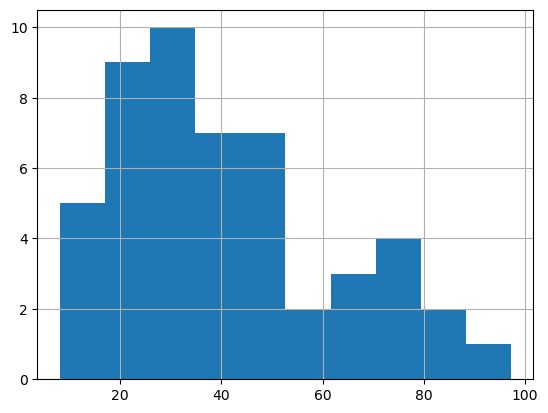

Informer MDAPE: 111.63918207569526


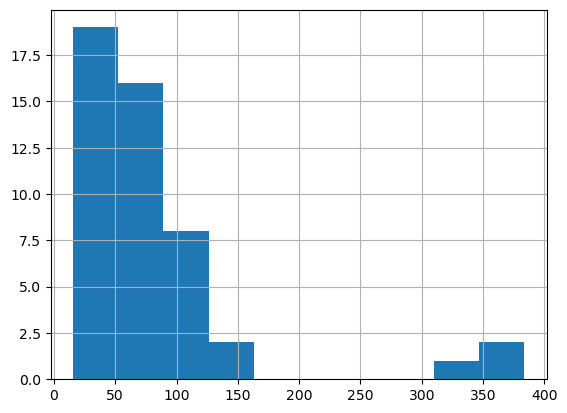

Informer ADJ_MAPE: 496.98821838506353


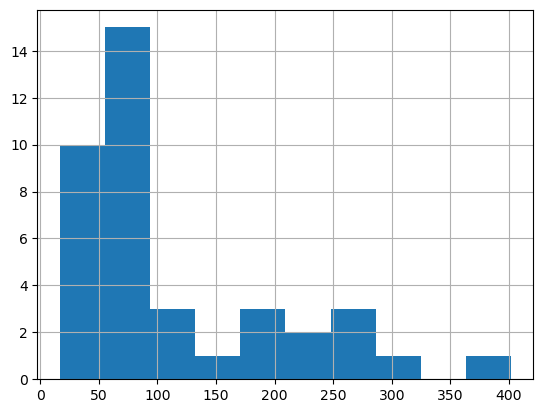

Informer MASE: 3.861058746473571


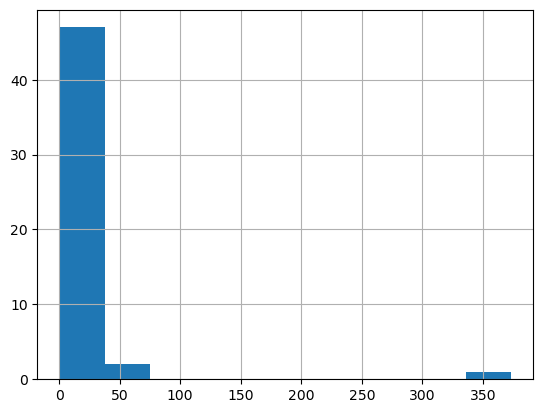

Informer CORRELATION: -0.002038677045277124


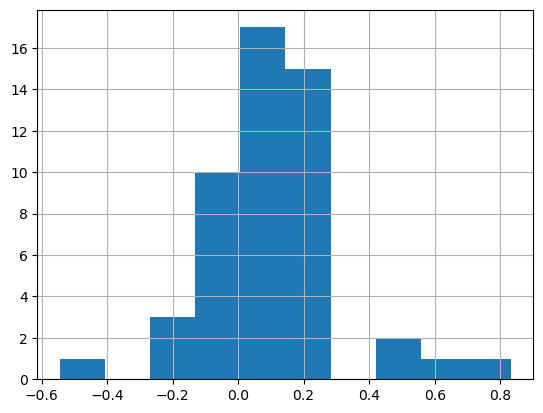

In [31]:
for SCORE_NM in ['SMAPE', 'MDAPE', 'ADJ_MAPE', 'MASE', 'CORRELATION']:
    print('Informer {}: {}'.format(SCORE_NM, np.mean([x for x in predictSummary_Informer_DF[SCORE_NM].values if x != float('inf')])))
    predictSummary_DL_DF[predictSummary_DL_DF[SCORE_NM] < 500][SCORE_NM].hist()
    plt.show()

SCINet SMAPE: 45.831014888310754


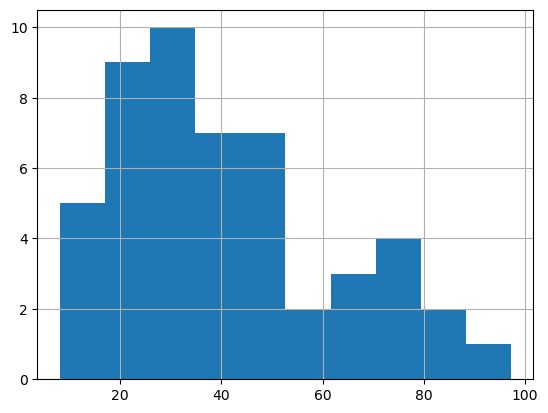

SCINet MDAPE: 133.78698077424932


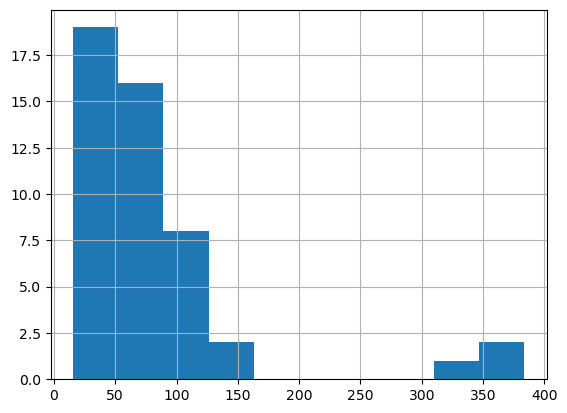

SCINet ADJ_MAPE: 826.7620955594645


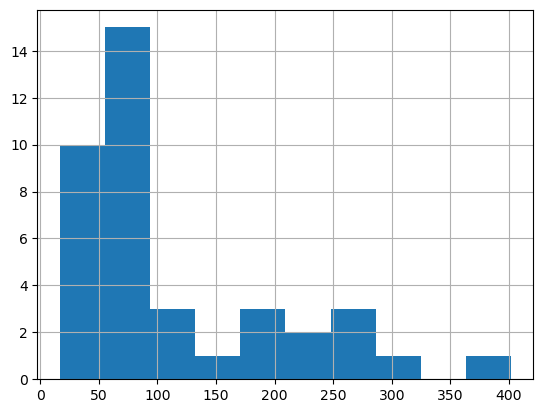

SCINet MASE: 15.68634693129868


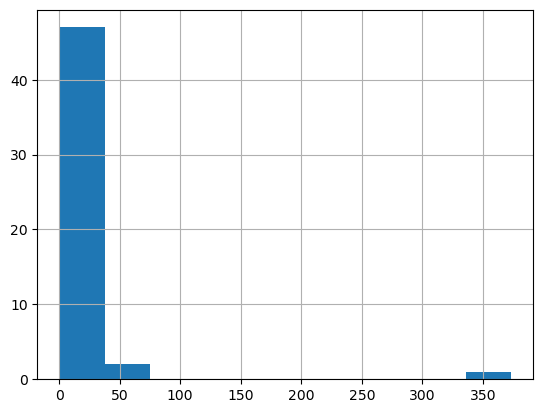

SCINet CORRELATION: -0.0045568520358773


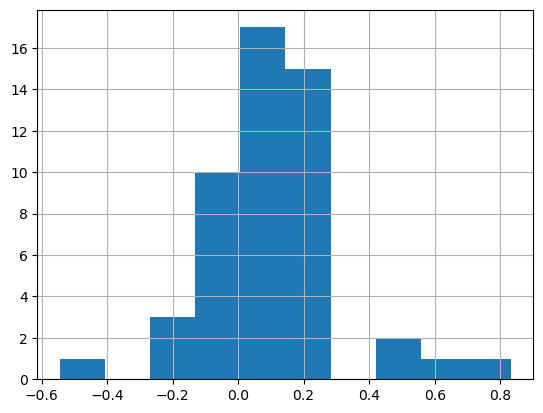

In [32]:
for SCORE_NM in ['SMAPE', 'MDAPE', 'ADJ_MAPE', 'MASE', 'CORRELATION']:
    print('SCINet {}: {}'.format(SCORE_NM, np.mean([x for x in predictSummary_SCINet_DF[SCORE_NM].values if x != float('inf')])))
    predictSummary_DL_DF[predictSummary_DL_DF[SCORE_NM] < 500][SCORE_NM].hist()
    plt.show()

NLinear SMAPE: 41.552962706885154


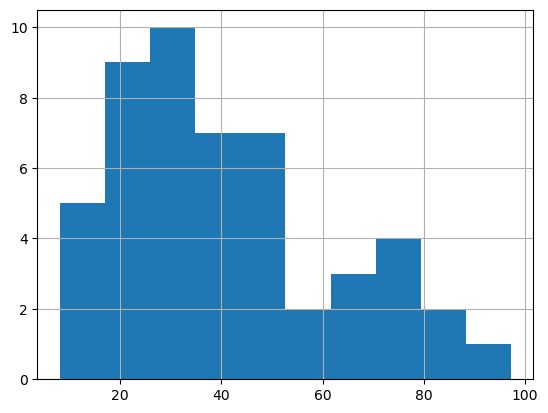

NLinear MDAPE: 210.10179635878492


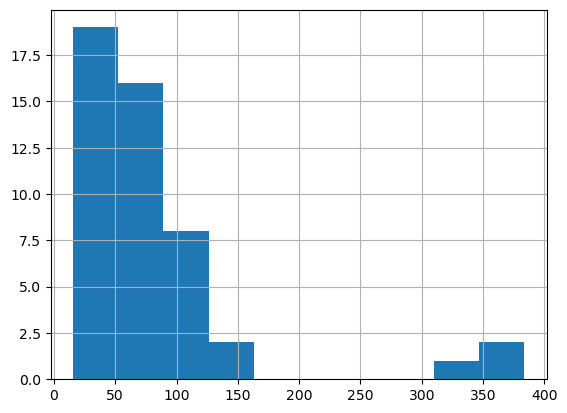

NLinear ADJ_MAPE: 635.1148979049651


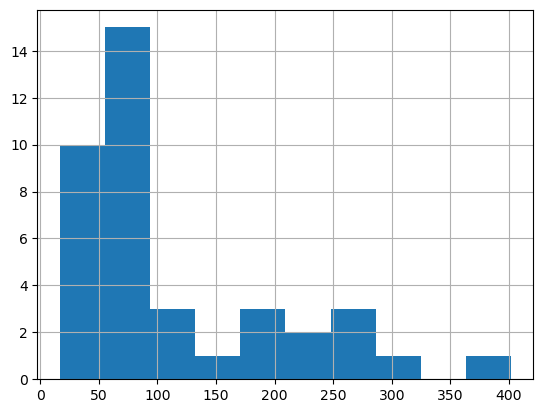

NLinear MASE: 12.386438007293293


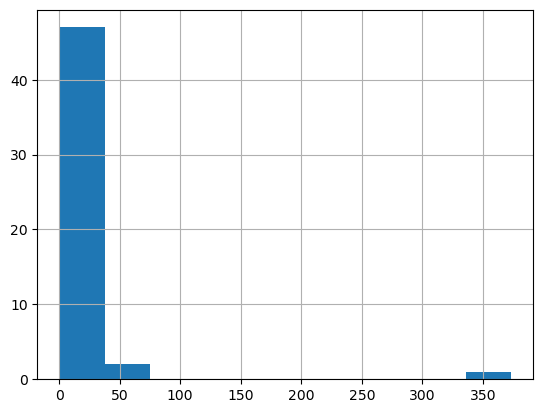

NLinear CORRELATION: 0.09136055247556979


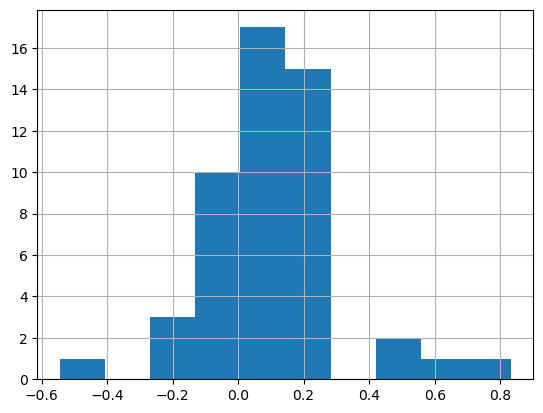

In [33]:
for SCORE_NM in ['SMAPE', 'MDAPE', 'ADJ_MAPE', 'MASE', 'CORRELATION']:
    print('NLinear {}: {}'.format(SCORE_NM, np.mean([x for x in predictSummary_NLinear_DF[SCORE_NM].values if x != float('inf')])))
    predictSummary_DL_DF[predictSummary_DL_DF[SCORE_NM] < 500][SCORE_NM].hist()
    plt.show()

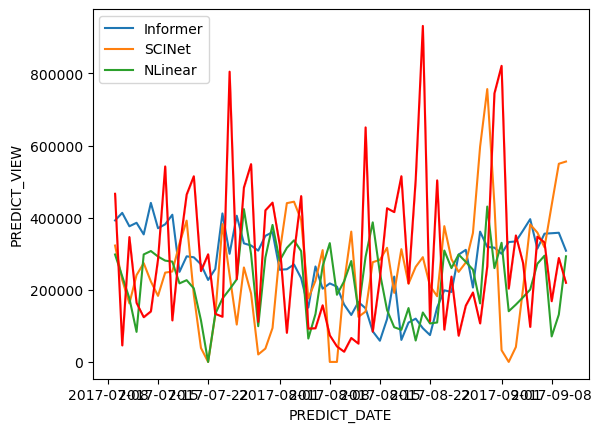

In [34]:
import seaborn as sns

sns.lineplot(x = 'PREDICT_DATE', y = 'PREDICT_VIEW', hue = 'ALG_GUB', 
             data = predictDay_Final[predictDay_Final['PAGE'] == predictDay_Final['PAGE'][1]])
sns.lineplot(x = 'PREDICT_DATE', y = 'REAL_VIEW', color = 'red',
             data = predictDay_Final[predictDay_Final['PAGE'] == predictDay_Final['PAGE'][1]])
plt.show()

In [170]:
## DL Score
print('===== SMAPE Average =====')
print(predictSummary_Final.groupby(['ALG_GUB'])['SMAPE'].mean())
print('\n===== SMAPE w/ ARIMA =====') ## 딥러닝 대신 ARIMA 모델을 사용했을 경우 SMAPE
print(predictSummary_Final['SMAPE_ARIMA'].mean())
print('\n===== Runtime(Seconds) with Algorithm =====')
print(predictSummary_Final.groupby(['ALG_GUB'])['RUN_TIME'].mean())

dl_Score_DF = pd.pivot_table(
    predictSummary_Final.groupby(['PAGE', 'ALG_GUB'])['SMAPE'].mean().reset_index(name = 'SMAPE'),
    values = 'SMAPE',
    index = 'PAGE',
    columns = 'ALG_GUB'
).reset_index(drop = False)
## Score Average
dl_Score_DF['DL_SAMPE_MEAN'] = dl_Score_DF[DL_Model_LS].apply(lambda row: np.mean([row[x] for x in DL_Model_LS]), axis = 1)
## Merge ARIMA SMAPE
dl_Score_DF = pd.merge(
    dl_Score_DF,
    predictSummary_Final[['PAGE', 'SMAPE_ARIMA']],
    on = 'PAGE'
)                      
## Sort
dl_Score_DF.sort_values('DL_SAMPE_MEAN', ascending=False, inplace=True)

print('\n===== Page SMAPE =====')
display(dl_Score_DF)

===== SMAPE Average =====
ALG_GUB
Informer   41.45
NLinear    41.55
SCINet     45.83
Name: SMAPE, dtype: float64

===== SMAPE w/ ARIMA =====
33.363838270041754

===== Runtime(Seconds) with Algorithm =====
ALG_GUB
Informer   1494.34
NLinear     151.90
SCINet      163.34
Name: RUN_TIME, dtype: float64

===== Page SMAPE =====


,PAGE,Informer,NLinear,SCINet,DL_SAMPE_MEAN,SMAPE_ARIMA
0,Ariana_Grande_en.wiki...,80.29,86.91,79.32,82.17,55.99
2,Ariana_Grande_en.wiki...,80.29,86.91,79.32,82.17,55.99
1,Ariana_Grande_en.wiki...,80.29,86.91,79.32,82.17,55.99
28,Google_en.wikipedia.o...,41.69,97.20,98.85,79.25,30.88
27,Google_en.wikipedia.o...,41.69,97.20,98.85,79.25,30.88
...,...,...,...,...,...,...
109,Spezial:Weblinksuche_...,16.82,12.18,18.41,15.80,12.87
108,Spezial:Weblinksuche_...,16.82,12.18,18.41,15.80,12.87
82,Special:Search_fr.wik...,16.23,12.37,17.91,15.50,15.46
81,Special:Search_fr.wik...,16.23,12.37,17.91,15.50,15.46


In [150]:
## SMAPE Plot
PAGE_NM = dl_Score_DF['PAGE'].values[::-1][1]
tmpSummary = predictSummary_Final[predictSummary_Final['PAGE'] == PAGE_NM]

FileNM = tmpSummary['LOSS_PLOT_FILE'].tolist()

Algorithm: Informer


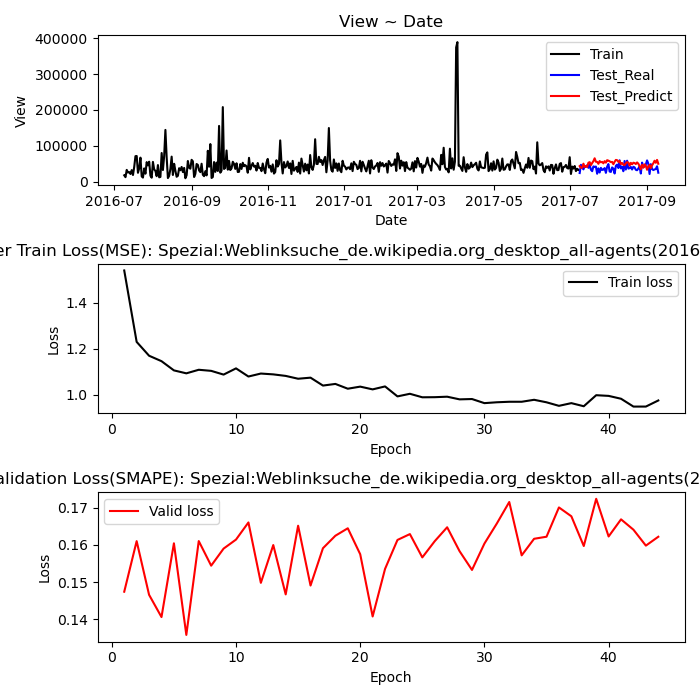

In [151]:
print('Algorithm: ' + FileNM[0].split('/')[1])
Image(f"result/{str(ANAL_DATE)[:10].replace('-', '')}/" + FileNM[0])

Algorithm: SCINet


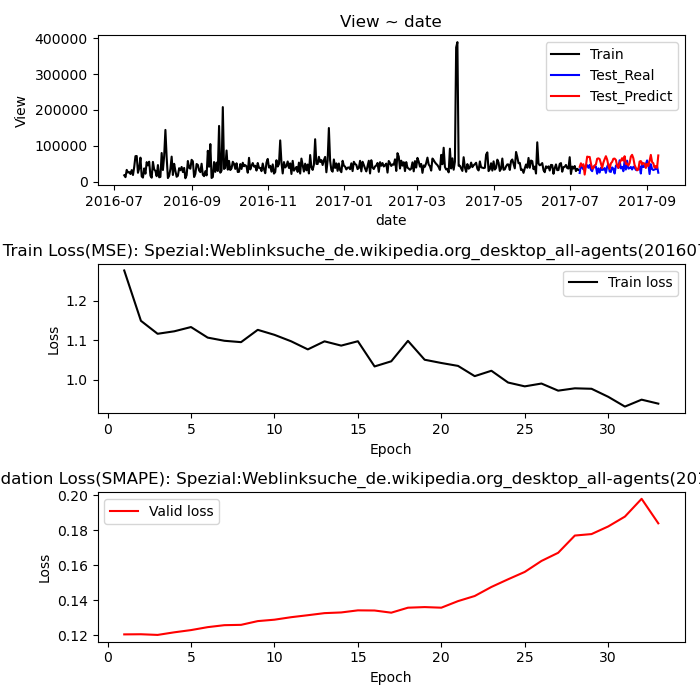

In [152]:
print('Algorithm: ' + FileNM[1].split('/')[1])
Image(f"result/{str(ANAL_DATE)[:10].replace('-', '')}/" + FileNM[1])

Algorithm: NLinear


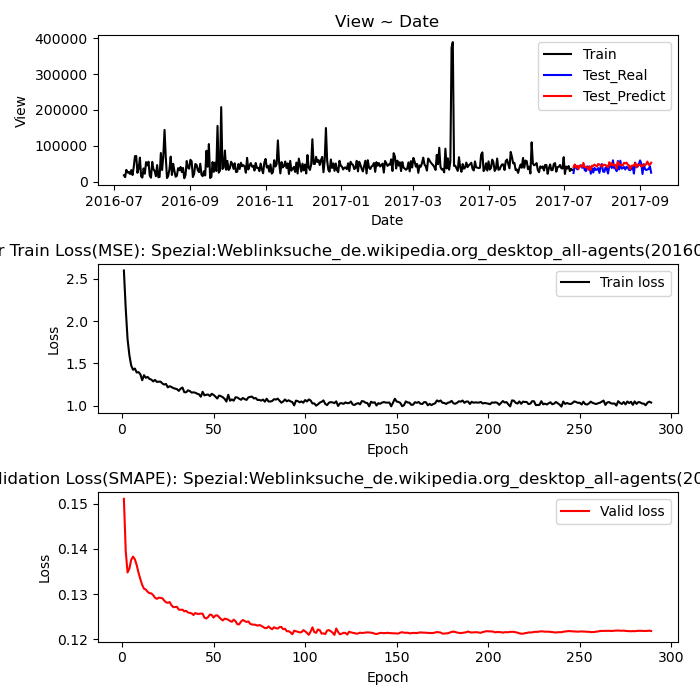

In [153]:
print('Algorithm: ' + FileNM[2].split('/')[1])
Image(f"result/{str(ANAL_DATE)[:10].replace('-', '')}/" + FileNM[2])

# 최종 결과 File

In [ ]:
# ## 일별 예측치
# predictDay_Total = pd.concat(
#     [
#         predictDay_DF,
#         predictDay_DL_DF
#     ],
#     axis = 0, ignore_index = True
# )
# ## 모델 요약
# predictSummary_Total = pd.concat(
#     [
#         predictSummary_DF,
#         predictSummary_DL_DF
#     ],
#     axis = 0, ignore_index = True
# )

In [ ]:
# predictDay_Total = pd.merge(
#     predictDay_Total,
#     keyData[['Page', 'Date', 'Id']],
#     on = ['Page', 'Date'],
#     how = 'left'
# )
# submissionData_DF = pd.merge(
#     submissionData_DF,
#     predictDay_Total,
#     on = 'Id',
#     how = 'left'
# )